In [9]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs
import contextily as cx
from geopandas.tools import overlay
import mapclassify as mc
import warnings
warnings.filterwarnings('ignore')

In [10]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)
# Dropping all of the columns which we will not use
# listingsNYC= listingsNYC.drop(['last_review','license','latitude','longitude','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
# listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64',
    'latitude':float,
    'longitude':float
}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC['neighbourhood'].unique().shape[0]
listingsNYC.describe()
listingsNYC['annual_revenue'] = (365 - listingsNYC['availability_365']) *  listingsNYC['price']
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC.loc[:,'log_pps']=np.log(listingsNYC['pps'])
# listingsNYC['price_bin'] = pd.cut(listingsNYC['price'], bins=range(0, 111, 10), right=False, labels=range(0, 110, 10))
df = listingsNYC[(listingsNYC['price']<2000) & (listingsNYC['price']>20) & (listingsNYC['minimum_nights'] < 30)]
df['price_bin'] = pd.cut(df['price'], bins=range(0, 2001, 20), right=False, labels=range(0, 2000, 20))
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license,pps,annual_revenue,log_price,log_pps,price_bin
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.662650,-73.994540,Entire home/apt,275,...,0.03,1,267,1,NaN,5775,26950,5.616771,8.661294,260
1,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.803800,-73.967510,Private room,75,...,0.73,1,0,0,NaN,150,27375,4.317488,5.010635,60
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.764570,-73.983170,Private room,68,...,3.38,1,79,50,NaN,136,19448,4.219508,4.912655,60
6,5803,"Lovely Room 1 in BEST AREA; Legal Rental, Spot...",9744,Laurie,Brooklyn,South Slope,40.668010,-73.987840,Private room,124,...,1.31,3,163,14,NaN,496,25048,4.820282,6.206576,120
8,7097,Perfect for Your Parents: Privacy + Garden,17571,Jane,Brooklyn,Fort Greene,40.691233,-73.972702,Entire home/apt,220,...,2.01,2,38,36,NaN,660,71940,5.393628,6.492240,220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41525,772714221060214808,Good Vibes at The Bronx,421264574,Aridio,Bronx,Unionport,40.828074,-73.847886,Entire home/apt,125,...,NaN,1,60,0,NaN,250,38125,4.828314,5.521461,120
41526,772716724205003579,2 bedroom Condo near West Village,481177884,Steven,Manhattan,Chelsea,40.740030,-73.997302,Entire home/apt,1114,...,NaN,2,355,0,NaN,3342,11140,7.015712,8.114325,1100
41527,771961589340472067,Habitación Privada,409771624,Camila,Queens,Sunnyside,40.742223,-73.923310,Private room,124,...,NaN,1,360,0,NaN,248,620,4.820282,5.513429,120
41528,771962449581256963,Romántico y natural,421601513,Juan Carlos,Manhattan,Washington Heights,40.847271,-73.943419,Private room,80,...,NaN,3,358,0,NaN,400,560,4.382027,5.991465,80


In [11]:
nyc_map = gpd.read_file("neighbourhoods.geojson")
nyc_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [12]:
nyc_map

,neighbourhood,neighbourhood_group,geometry
0,Bayswater,Queens,"MULTIPOLYGON (((-73.76671 40.61491, -73.76825 ..."
1,Allerton,Bronx,"MULTIPOLYGON (((-73.84860 40.87167, -73.84582 ..."
2,City Island,Bronx,"MULTIPOLYGON (((-73.78282 40.84392, -73.78257 ..."
3,Ditmars Steinway,Queens,"MULTIPOLYGON (((-73.90160 40.76777, -73.90391 ..."
4,Ozone Park,Queens,"MULTIPOLYGON (((-73.83754 40.69136, -73.83108 ..."
...,...,...,...
228,Westchester Square,Bronx,"MULTIPOLYGON (((-73.84294 40.84640, -73.83913 ..."
229,Westerleigh,Staten Island,"MULTIPOLYGON (((-74.13131 40.62633, -74.13192 ..."
230,Williamsbridge,Bronx,"MULTIPOLYGON (((-73.86722 40.86969, -73.86701 ..."
231,Williamsburg,Brooklyn,"MULTIPOLYGON (((-73.95757 40.72510, -73.95300 ..."


In [13]:
neighborhood_counts = df.groupby('neighbourhood').count()
neighborhood_counts=neighborhood_counts[['id']]
neighborhood_counts.rename(columns={'id':'neighborhood_count'}, inplace=True)
neighborhood_meds = df.groupby('neighbourhood').median()
neighborhood_meds=neighborhood_meds[['latitude','longitude','price','annual_revenue']]
neighborhood_meds_and_counts= pd.merge(neighborhood_counts,neighborhood_meds, on='neighbourhood')
neighborhood_meds_and_counts

,neighborhood_count,latitude,longitude,price,annual_revenue
neighbourhood,,,,,
Allerton,41,40.865910,-73.860500,99.0,3976.0
Arden Heights,2,40.557143,-74.175808,115.0,2438.0
Arrochar,12,40.592645,-74.068570,112.0,20995.0
Arverne,84,40.593695,-73.795325,164.5,18058.0
Astoria,397,40.766138,-73.921580,100.0,13959.0
...,...,...,...,...,...
Windsor Terrace,61,40.656600,-73.978970,150.0,23436.0
Woodhaven,61,40.692040,-73.858310,87.0,17464.0
Woodlawn,10,40.898760,-73.863993,120.5,16790.0


In [14]:
geo_neighborhood_meds_and_counts = gpd.GeoDataFrame(neighborhood_meds_and_counts,geometry = gpd.points_from_xy(neighborhood_meds_and_counts.longitude, neighborhood_meds_and_counts.latitude))
geo_neighborhood_meds_and_counts

,neighborhood_count,latitude,longitude,price,annual_revenue,geometry
neighbourhood,,,,,,
Allerton,41,40.865910,-73.860500,99.0,3976.0,POINT (-73.86050 40.86591)
Arden Heights,2,40.557143,-74.175808,115.0,2438.0,POINT (-74.17581 40.55714)
Arrochar,12,40.592645,-74.068570,112.0,20995.0,POINT (-74.06857 40.59265)
Arverne,84,40.593695,-73.795325,164.5,18058.0,POINT (-73.79532 40.59369)
Astoria,397,40.766138,-73.921580,100.0,13959.0,POINT (-73.92158 40.76614)
...,...,...,...,...,...,...
Windsor Terrace,61,40.656600,-73.978970,150.0,23436.0,POINT (-73.97897 40.65660)
Woodhaven,61,40.692040,-73.858310,87.0,17464.0,POINT (-73.85831 40.69204)
Woodlawn,10,40.898760,-73.863993,120.5,16790.0,POINT (-73.86399 40.89876)


In [15]:
scheme_price = mc.Quantiles(geo_neighborhood_meds_and_counts['price'], k=5)
scheme_annual_revenue =  mc.Quantiles(geo_neighborhood_meds_and_counts['annual_revenue'], k=5)

Text(0.5, 1.0, 'Median Price of Neighborhood Listing')

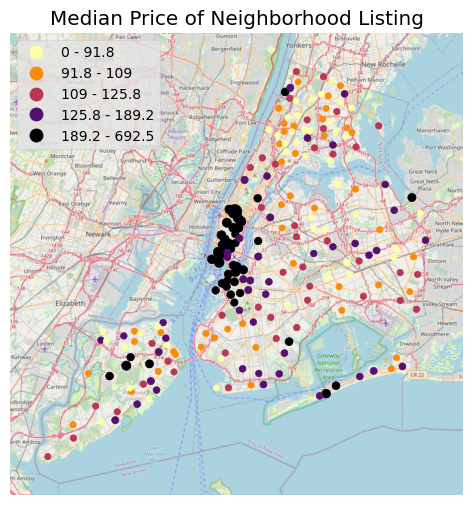

In [16]:
ax = gplt.webmap(nyc_map,projection=gcrs.WebMercator())
gplt.pointplot(
    geo_neighborhood_meds_and_counts,
    hue='price',
    scale='price', limits=(4, 10),
    legend=True, legend_var='hue',
    scheme=scheme_price,
    cmap= 'inferno_r',
    ax=ax)
plt.title('Median Price of Neighborhood Listing')

Text(0.5, 1.0, 'Average Annual Revenue of Neighborhood Listing')

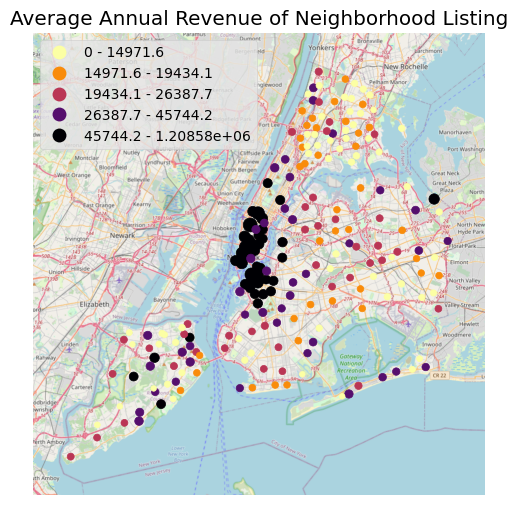

In [36]:
ax = gplt.webmap(nyc_map,projection=gcrs.WebMercator())
gplt.pointplot(
    geo_neighborhood_meds_and_counts,
    hue='annual_revenue',
    scale='annual_revenue', limits=(4, 10),
    legend=True, legend_var='hue',
    scheme=scheme_annual_revenue,
    cmap= 'inferno_r',
    ax=ax)
plt.title('Average Annual Revenue of Neighborhood Listing')